<a href="https://colab.research.google.com/github/JaladiRishitha/U-Net_GI-tract-segmentation/blob/main/unet_GI_tract_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# directories

main_dir = '/content/drive/My Drive'
train_folder = '/content/drive/MyDrive/train_set1'
test_folder = os.path.join(main_dir, 'test')

In [ ]:
import os


# Check if folder exists
if os.path.exists(train_folder):
    # Get list of files and directories in folder
    files = os.listdir(train_folder)

    if len(files) > 0:
        # Folder contains files
        print(f"The folder {train_folder} contains {len(files)} files.")
    else:
        # Folder is empty
        print(f"The folder {train_folder} is empty.")
else:
    # Folder does not exist
    print(f"The folder {train_folder} does not exist.")


The folder /content/drive/MyDrive/train_set1 contains 1 files.


## 1. Download train dataset

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/train.csv')
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


## 2. Investigate train dataset and preprocess it

In [ ]:
print(len(train_df))
print('class null values: {:.2f}%'.format(train_df['class'].isna().sum() / len(train_df) * 100))
print('segmentation null values: {:.2f}%'.format(train_df['segmentation'].isna().sum() / len(train_df) * 100))

115488
class null values: 0.00%
segmentation null values: 70.64%


In [ ]:
# how many mask-classes are presented
classes = train_df.loc[:, 'class'].unique().tolist()
classes

['large_bowel', 'small_bowel', 'stomach']

In [ ]:
# does each image have three masks (by number of classes)?
for cl in classes:
    print('{}: {}'.format(cl, len(train_df[train_df['class'] == cl])))

large_bowel: 38496
small_bowel: 38496
stomach: 38496


In [ ]:
# group train dataset by id, add 3 new columns: 'large_bowel', 'small_bowel', 'stomach'
#--------------------------------------------------------------------------------------
train_df_grouped = train_df.copy()
train_df_grouped.set_index('id', inplace = True)

seg_list = []
for cl in classes:
    seg = train_df_grouped[train_df_grouped['class'] == cl]['segmentation']
    seg.name = cl
    seg_list.append(seg)

train_df_grouped = pd.concat(seg_list, axis=1).reset_index()
train_df_grouped.fillna('', inplace = True)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,,,
1,case123_day20_slice_0002,,,
2,case123_day20_slice_0003,,,
3,case123_day20_slice_0004,,,
4,case123_day20_slice_0005,,,


In [ ]:
def get_case_day_slice(x):

    #--------------------------------------------------------------------------------------
    # function that parses a string (full_path or image_id)
    # and returns case, day, slice_
    #--------------------------------------------------------------------------------------

    case = re.search('case[0-9]+', x).group()[len('case'):]
    day = re.search('day[0-9]+', x).group()[len('day'):]
    slice_ = re.search('slice_[0-9]+', x).group()[len('slice_'):]
    # print(case, day, slice_)
    return case, day, slice_

In [ ]:
from glob import glob
import re

case_day_slice = ['case', 'day', 'slice_']

def process_df(df, path):

    #--------------------------------------------------------------------------------------
    # add new columns:
    # ['case', 'day', 'slice_']
    # and
    # 'full_path'
    #--------------------------------------------------------------------------------------

    # df = df.copy()
    # df.loc[:, case_day_slice] = df.id.apply(get_case_day_slice).to_list()

    # # get list of all images
    # all_images = glob(os.path.join(path, "**", "*.png"), recursive = True)
    # img_df = pd.DataFrame(all_images, columns = ['full_path'])
    # img_df.loc[:, case_day_slice] = img_df.full_path.apply(get_case_day_slice).to_list()

    # return df.merge(img_df, on = case_day_slice, how = 'left')


  df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
  df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
  df["slice"] = df["id"].apply(lambda x: x.split("_")[3])

  TRAIN_DIR="/content/drive/My Drive/train_set1"
  all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
  print(all_train_images)
  x = all_train_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train
  print(x)
  path_partial_list = []
  for i in range(0, df.shape[0]):
      path_partial_list.append(os.path.join(x,
                            "case"+str(df["case"].values[i]),
                            "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                            "scans",
                            "slice_"+str(df["slice"].values[i])))
  df["path_partial"] = path_partial_list
  #--------------------------------------------------------------------------
  path_partial_list = []
  for i in range(0, len(all_train_images)):
      path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
  print('full_path',path_partial_list)

  tmp_df = pd.DataFrame()
  tmp_df['path_partial'] = path_partial_list
  tmp_df['full_path'] = all_train_images
  print('all',all_train_images[:-4])
  #--------------------------------------------------------------------------
  return df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])

In [ ]:
# Remove mislabeled training data

# thank you:
# https://www.kaggle.com/code/caomaobin/uw-madison-data-incorrect-in-case7day0
# https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda

train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 7) | (train_df_grouped['day'] != 0)].reset_index(drop = True)
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 81) | (train_df_grouped['day'] != 30)].reset_index(drop = True)

## 3. Encode/decode RLE mask functions

In [ ]:
# see: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

# from competition overview:
# "pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).""

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

## 4. Display several examples

### 4.1 Investigate different ways to open/represent image

This part of notebook appeared when I was wondering what approach to open/decode images would be better to use for exact this project. You can safely skip this part of the notebook

In [ ]:
# get an example of image having non-null 'large_bowel' mask
example_row = train_df_grouped[train_df_grouped['large_bowel'] != ''].iloc[0, :]
example_row

id                                       case15_day20_slice_0058
large_bowel    28436 5 28701 7 28967 8 29232 9 29498 9 29765 ...
small_bowel                                                     
stomach        25205 5 25468 12 25733 15 25998 17 26263 19 26...
case                                                          15
day                                                           20
slice                                                       0058
full_path      /content/drive/My Drive/train_set1/train/case1...
Name: 57, dtype: object

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_path = example_row.full_path
img_path

'/content/drive/My Drive/train_set1/train/case15/case15_day20/scans/slice_0058_266_266_1.50_1.50.png'

In [ ]:
# display an image
# + image size
# + values of 100th row
import matplotlib.pyplot as plt

def print_img_info(img):
    # print(img.shape)
    img_arr = np.asarray(img)
    print(img_arr.shape)
    print(img_arr[100])
    plt.imshow(img)

(266, 266)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.00028992 0.00022889 0.00021363 0.00021363
 0.00028992 0.0002594  0.00022889 0.00027466 0.00024414 0.0002594
 0.00038148 0.00028992 0.00032044 0.0002594  0.00036622 0.00035096
 0.00027466 0.00024414 0.00030518 0.00028992 0.00024414 0.00024414
 0.00039673 0.00036622 0.00042725 0.0003357  0.00028992 0.00024414
 0.00039673 0.00039673 0.00035096 0.00032044 0.00030518 0.00042725
 0.00192264 0.00323491 0.00370794 0.0037995  0.0034638  0.00352483
 0.00347906 0.00315862 0.00303655 0.00178531 0.00080873 0.00056458
 0.00079347 0.00151064 0.00173953 0.00181582 0.00122072 0.00077821
 0.00082399 0.00094606 0.00102235 0.00122072 0.00128176 0.0011902
 0.00138857 0.00123598 0.00132753 0.00141909 0.00125124 0.00123598
 0.00122072 0.00138857 0.00158694 0.00180056 0.00151064 0.00115969
 0.00122072 0.00111391 0.00123598 0.00129702 0.00122072 0.00094606
 0.00120546 0.00155642 0.00141909 0.00134279 0.0010071  0.001

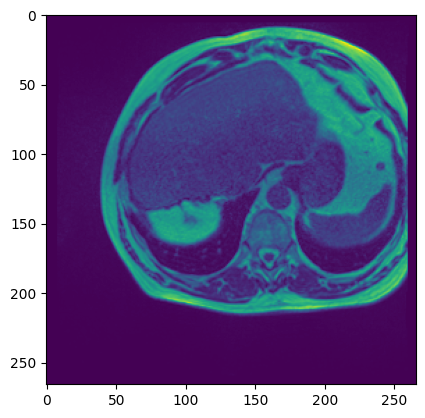

In [ ]:
# matplotlib

# from documentation:
# PNG images are returned as float arrays (0-1).
# All other formats are returned as int arrays, with a bit depth determined by the file's contents.

# all values divided by 255 * 255

import matplotlib.image as mpimg
print_img_info(mpimg.imread(img_path, format = 'png'))

(266, 266)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0]


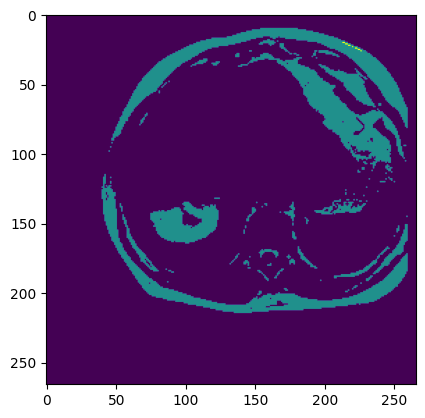

In [ ]:
# cv2
# each value - [0, 255]

import cv2
print_img_info(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))

(266, 266)
[  0   0   0   0   0   0   0   0  19  15  14  14  19  17  15  18  16  17
  25  19  21  17  24  23  18  16  20  19  16  16  26  24  28  22  19  16
  26  26  23  21  20  28 126 212 243 249 227 231 228 207 199 117  53  37
  52  99 114 119  80  51  54  62  67  80  84  78  91  81  87  93  82  81
  80  91 104 118  99  76  80  73  81  85  80  62  79 102  93  88  66  82
  98  79  81  74  81  79  63  85  94  81  96 104  92  77  65  85  92  80
  71  63  74  89  89  91  81  74  81  78  74  77  74  75  71  78  73  73
  57  35  39  37  82 101  91  75  57  85  63  56  71  73  83  79  75  73
  51  69  81  81 101  88  75  72  66  54  75  65  75  95  88  73  66  77
  82  61  45  55  74  66  63  64  63  60  52  64  77  75  77  66  70  60
  69  68  43  43  53  81  94 112  80  89 124 127 118  72  29  37  58  74
  77  83  82  74  58  56  53  57  68  60  46  41  68  58  48  73 124 185
 226 219 242 244 257 269 244 239 229 225 224 246 239 226 198 235 246 258
 284 284 290 262 288 281 295 290 301 300

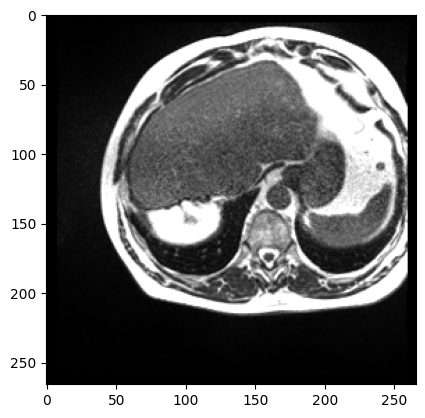

In [ ]:
import PIL
print_img_info(PIL.Image.open(img_path, formats = ['PNG']))

(266, 266)
[  0.   0.   0.   0.   0.   0.   0.   0.  19.  15.  14.  14.  19.  17.
  15.  18.  16.  17.  25.  19.  21.  17.  24.  23.  18.  16.  20.  19.
  16.  16.  26.  24.  28.  22.  19.  16.  26.  26.  23.  21.  20.  28.
 126. 212. 243. 249. 227. 231. 228. 207. 199. 117.  53.  37.  52.  99.
 114. 119.  80.  51.  54.  62.  67.  80.  84.  78.  91.  81.  87.  93.
  82.  81.  80.  91. 104. 118.  99.  76.  80.  73.  81.  85.  80.  62.
  79. 102.  93.  88.  66.  82.  98.  79.  81.  74.  81.  79.  63.  85.
  94.  81.  96. 104.  92.  77.  65.  85.  92.  80.  71.  63.  74.  89.
  89.  91.  81.  74.  81.  78.  74.  77.  74.  75.  71.  78.  73.  73.
  57.  35.  39.  37.  82. 101.  91.  75.  57.  85.  63.  56.  71.  73.
  83.  79.  75.  73.  51.  69.  81.  81. 101.  88.  75.  72.  66.  54.
  75.  65.  75.  95.  88.  73.  66.  77.  82.  61.  45.  55.  74.  66.
  63.  64.  63.  60.  52.  64.  77.  75.  77.  66.  70.  60.  69.  68.
  43.  43.  53.  81.  94. 112.  80.  89. 124. 127. 118.  72.  29. 

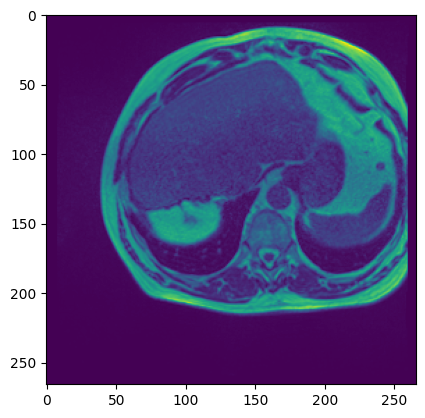

In [ ]:
# keras
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img(img_path, color_mode = "grayscale")
img = tf.keras.preprocessing.image.img_to_array(img)
print_img_info(img[:, :, 0])

In [ ]:
mask_seq = example_row.large_bowel

(266, 266, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


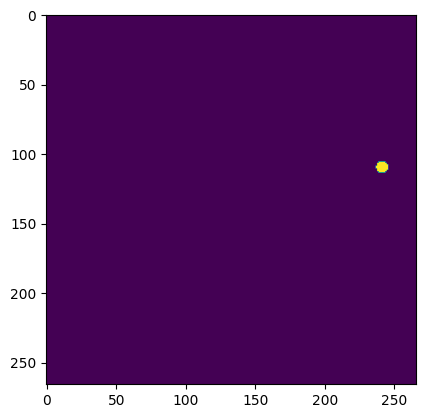

In [ ]:
mask = rle_decode(mask_seq, img.shape)
print(mask.shape)
print(mask[90, :, 0])
plt.imshow(mask)

(128, 128, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


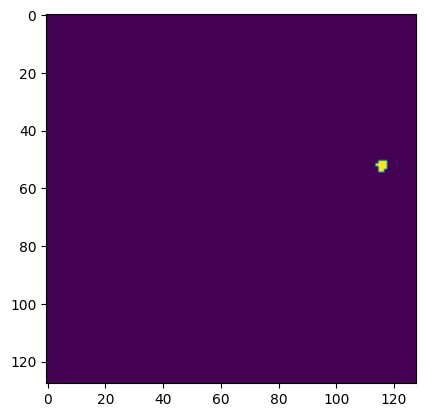

In [ ]:
small_mask = tf.image.resize(mask, (128,128), method = 'nearest').numpy()
print(small_mask.shape)
print(small_mask[40, :, 0])
plt.imshow(small_mask)

(256, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


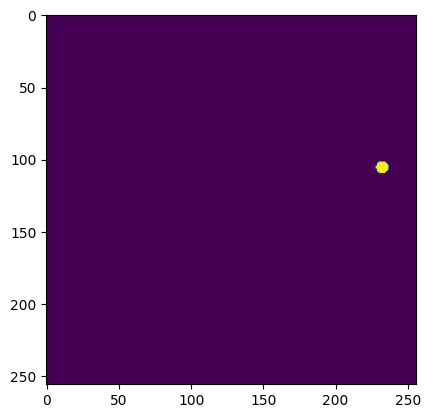

In [ ]:
small_mask = cv2.resize(mask, (256,256))
print(small_mask.shape)
print(small_mask[40, :])
plt.imshow(small_mask)

### 4.2 Display several examples

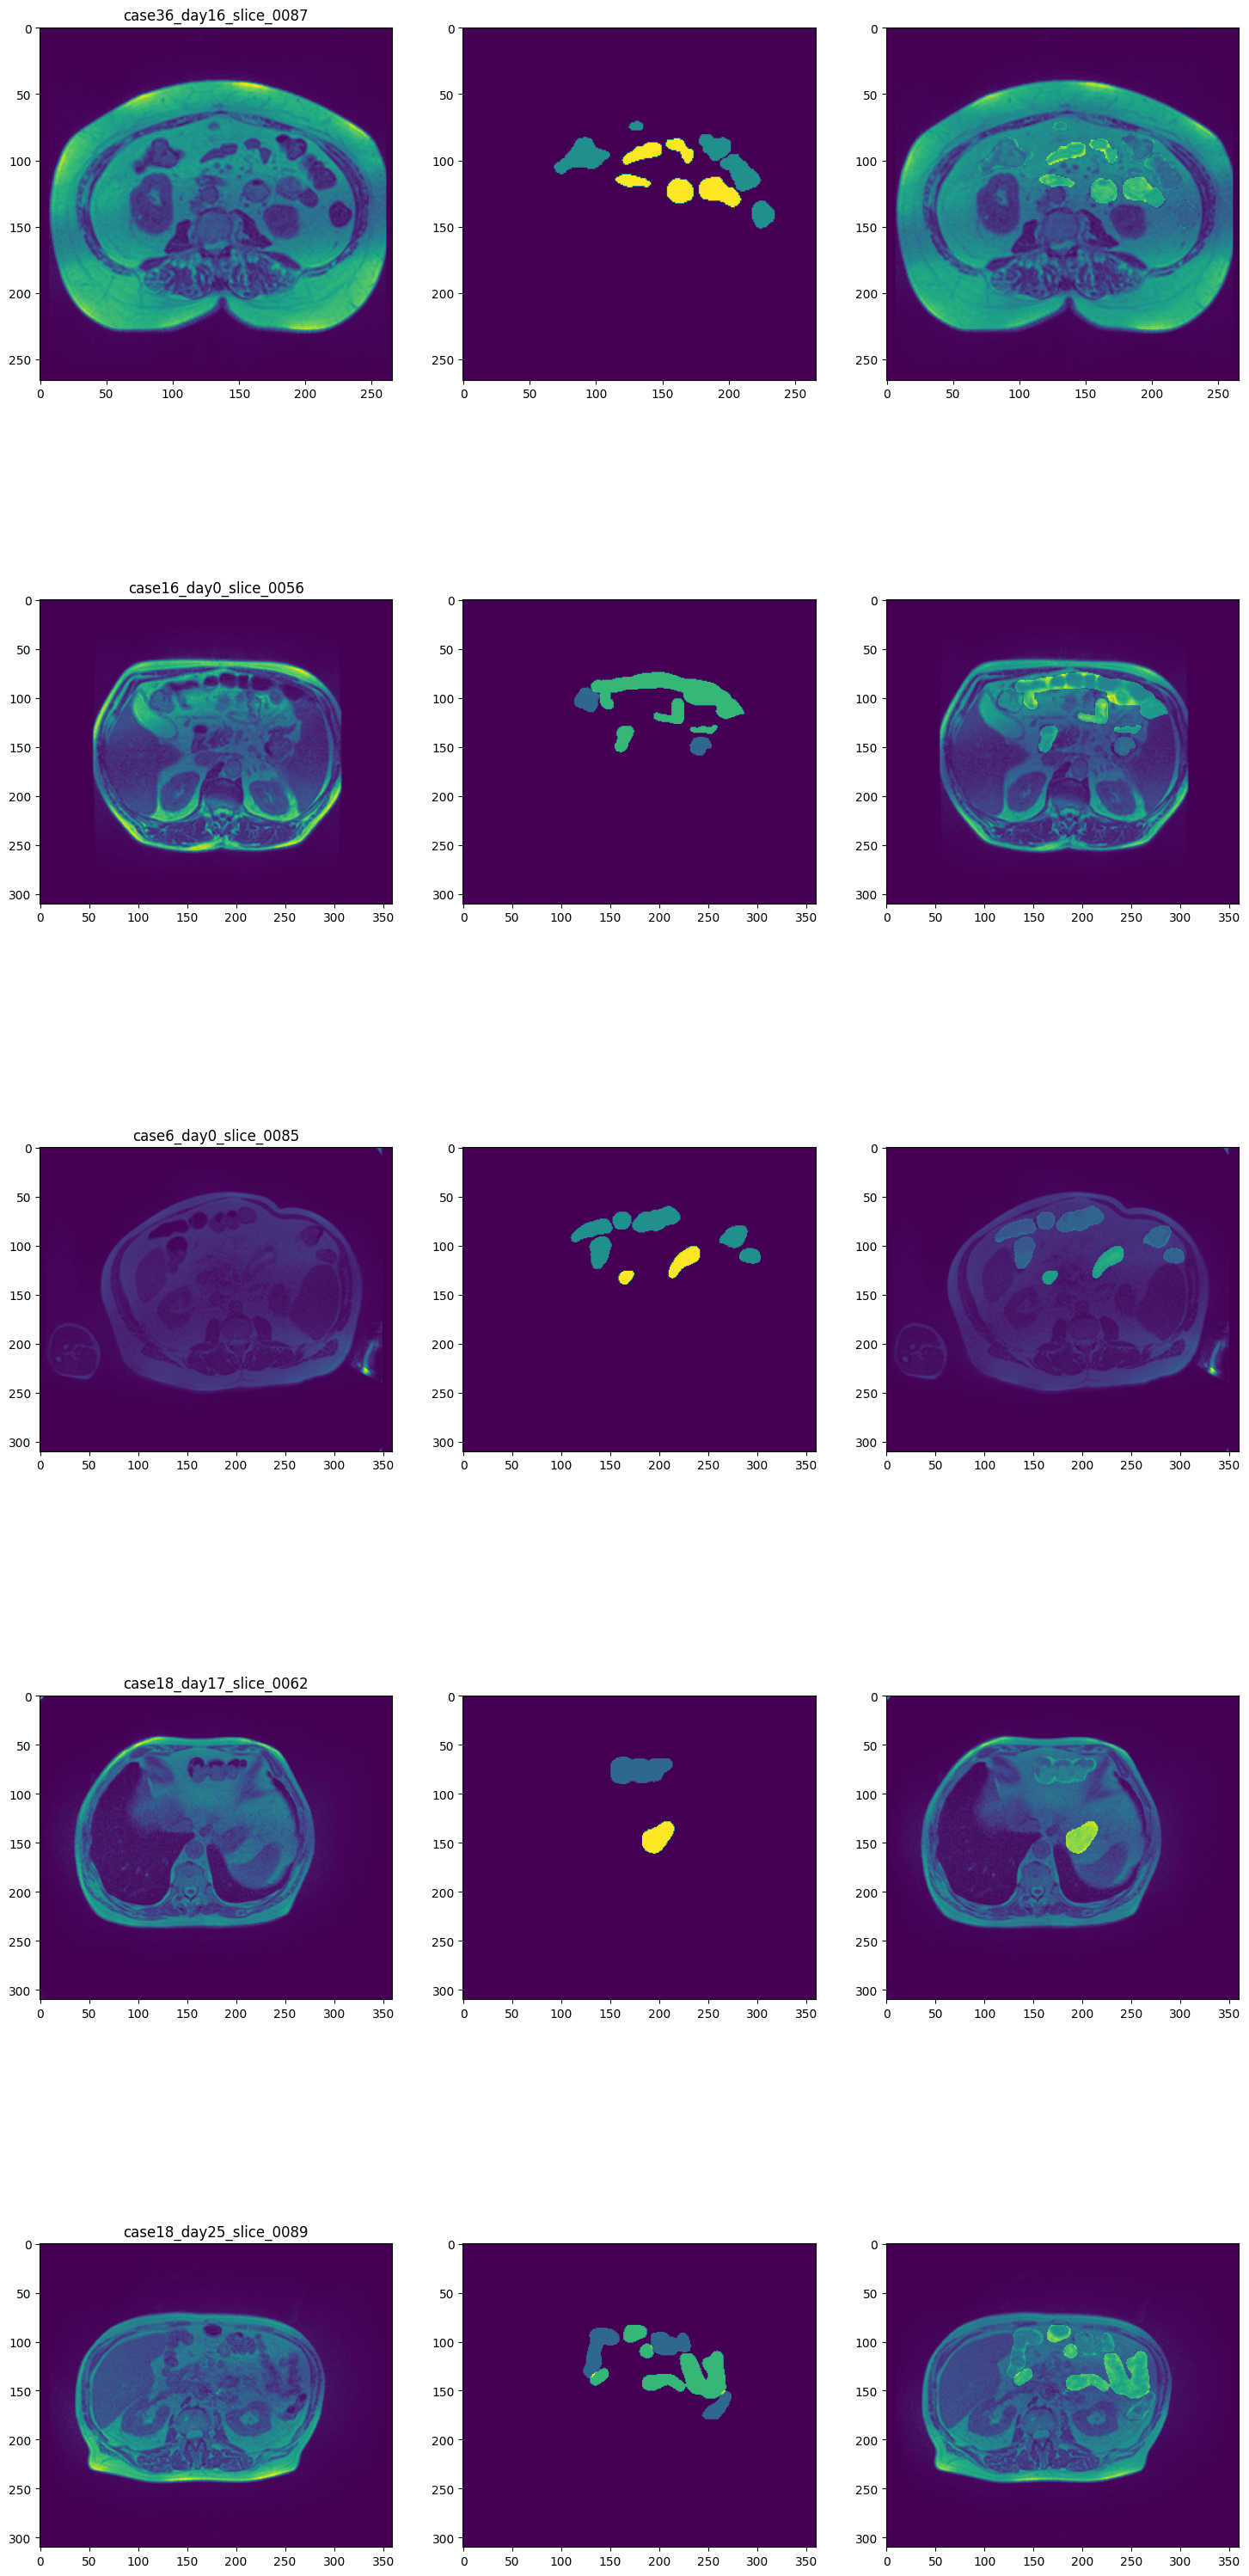

In [ ]:
num = 5
segmentation_df_example = train_df_grouped[train_df_grouped.large_bowel != ''].sample(num)

fig, ax = plt.subplots(num, 3, figsize=(18, 8*num))
for i in range(num):
    record = segmentation_df_example.iloc[i, :]

    img = mpimg.imread(record.full_path, format = 'png')
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(record.id)

    mask = np.zeros(img.shape)
    for j, cl in enumerate(classes):
        mask += rle_decode(record[cl], img.shape)*(j + 1) / 4 * np.max(img)
    ax[i, 1].imshow(mask)

    ax[i, 2].imshow(img + mask)

## 5. Data Generator

In [ ]:
from enum import Enum, auto

class GeneratorMode(Enum):
    TRAIN = auto()
    TEST = auto()

In [ ]:
#It retrieves the image and its corresponding masks from the dataframe and returns them in a tuple

import tensorflow as tf
img_size = 256

class ImageDataGen(tf.keras.utils.Sequence):

    def __init__(self,
                 df,
                 batch_size,
                 mode = GeneratorMode.TRAIN):

        self.df = df
        self.batch_size = batch_size
        self.image_size = img_size
        self.mode = mode

        self.len = len(df)

    def __getitem__(self, index):

        start, end = index * self.batch_size, (index + 1) * self.batch_size

        images = np.zeros((self.batch_size, self.image_size, self.image_size, 1))
        masks = np.zeros((self.batch_size, self.image_size, self.image_size, len(classes)))
        for i , pos in enumerate(range(start, end)):
            row = self.df.iloc[pos, :]

            #image
            image = tf.keras.preprocessing.image.load_img(row['full_path'], color_mode = "grayscale")
            image = tf.keras.preprocessing.image.img_to_array(image)
            image_shape = image.shape

            image = tf.image.resize(image, (self.image_size, self.image_size), method = 'nearest').numpy()
            image = image.reshape((self.image_size, self.image_size))
            images[i, :, :, 0] = image / 255.

            # masks (only train/val mode)
            if self.mode == GeneratorMode.TRAIN:
                for j, cl in enumerate(classes):
                    feat = row[cl]
                    mask = rle_decode(feat, image_shape)
                    mask = tf.image.resize(mask, (self.image_size, self.image_size), method = 'nearest').numpy()
                    mask = mask.reshape((self.image_size, self.image_size))
                    masks[i, :, :, j] = mask

        return (images, masks) if self.mode == GeneratorMode.TRAIN else images


    def __len__(self):
        return self.len // self.batch_size

In [ ]:
# split train dataset into train and validation parts

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_df_grouped, test_size = 0.1, shuffle = True, random_state = 42)

In [ ]:
train_data_gen = ImageDataGen(train_set, 32)
val_data_gen = ImageDataGen(val_set, 32)

## 6. Unet Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def build_unet_model():
    inputs = layers.Input(shape=(img_size, img_size, 1))

    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = double_conv_block(p4, 1024)

    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    outputs = layers.Conv2D(len(classes), 1, padding="same", activation = "sigmoid")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
# metrics

# https://www.kaggle.com/code/samuelcortinhas/uwmgi-segmentation-unet-keras-inference

from keras import backend as K

# addind a 'smooth' value which equals to 1 just to avoid dividing by 0 in case y_true and y_pred consist of 0
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#intersection over union coefficient
def iou_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# LOSS func

# from tensorflow.keras.losses import BinaryCrossentropy

# def loss_f(y_true, y_pred):
#     bce = BinaryCrossentropy()
#     return dice_loss(y_true, y_pred) + bce(y_true, y_pred)

# def dice_loss(y_true, y_pred):
#     return 1. - dice_coef(y_true, y_pred)


from tensorflow.keras.losses import BinaryCrossentropy

def loss_f(y_true, y_pred):
    bce = BinaryCrossentropy()
    alpha = 0.5   # set the weighting factor for dice loss
    return alpha * dice_loss(y_true, y_pred) + (1 - alpha) * bce(y_true, y_pred)

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)


In [ ]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                   loss = loss_f, metrics = [dice_coef, iou_coef])

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2, verbose = 1)

In [ ]:
EPOCHS = 25
history = unet_model.fit(train_data_gen,
                         validation_data = val_data_gen,
                         epochs = EPOCHS, callbacks = [early_stop, reduce_lr])
unet_model.save('model.h5')


Epoch 1/25
238/238 [==============================] - 2075s 8s/step - loss: 0.5413 - dice_coef: 0.0580 - iou_coef: 0.0246 - val_loss: 0.4838 - val_dice_coef: 0.0812 - val_iou_coef: 0.0534 - lr: 1.0000e-04
Epoch 2/25
238/238 [==============================] - 620s 3s/step - loss: 0.4267 - dice_coef: 0.1976 - iou_coef: 0.1077 - val_loss: 0.4122 - val_dice_coef: 0.2184 - val_iou_coef: 0.1170 - lr: 1.0000e-04
Epoch 3/25
238/238 [==============================] - 620s 3s/step - loss: 0.3742 - dice_coef: 0.2986 - iou_coef: 0.2304 - val_loss: 0.3650 - val_dice_coef: 0.3236 - val_iou_coef: 0.2122 - lr: 1.0000e-04
Epoch 4/25
238/238 [==============================] - 623s 3s/step - loss: 0.3091 - dice_coef: 0.4216 - iou_coef: 0.3269 - val_loss: 0.2918 - val_dice_coef: 0.4503 - val_iou_coef: 0.4302 - lr: 1.0000e-04
Epoch 5/25
238/238 [==============================] - 628s 3s/step - loss: 0.2226 - dice_coef: 0.5865 - iou_coef: 0.4659 - val_loss: 0.1910 - val_dice_coef: 0.6436 - val_iou_coef: 0.5

**Mask** R-CNN model

## 7. Print acc/loss

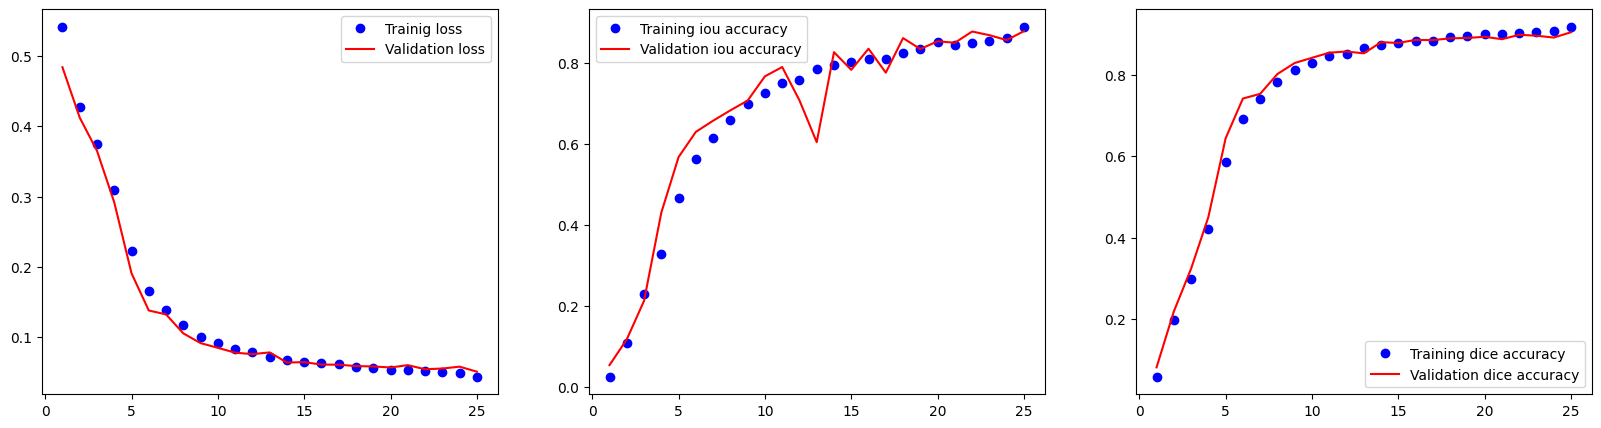

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

iou_coef = history.history['iou_coef']
val_iou_coef = history.history['val_iou_coef']

dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']


epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 5))

# loss
plt.subplot(1,3,1)
plt.plot(epochs, loss, 'bo', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

# iou
plt.subplot(1,3,2)
plt.plot(epochs, iou_coef, 'bo', label = 'Training iou accuracy')
plt.plot(epochs, val_iou_coef, 'r', label = 'Validation iou accuracy')
plt.legend()

# dice
plt.subplot(1,3,3)
plt.plot(epochs, dice_coef, 'bo', label = 'Training dice accuracy')
plt.plot(epochs, val_dice_coef, 'r', label = 'Validation dice accuracy')
plt.legend()

plt.show()